In [1]:
import random
import math

# Pruebas Trapecios

In [2]:
def f(x):
    return 1.0 / math.sqrt(1-x*x)

In [3]:
math.nextafter(1.0, 0.0)

0.9999999999999999

In [4]:
npes = 8
iteraciones_total = 10000
iteraciones = iteraciones_total // npes

total = 0.0

for i in range(npes):
    start_x = (i*iteraciones) / iteraciones_total
    step_x = (1.0 / npes) / iteraciones
        
    prev_f = f(start_x)
    for j in range(1,iteraciones):
        if i == 0 and j == 0:
            continue
        if i == npes -1 and j == iteraciones -1:
            continue
        
        actual_x = start_x + step_x*j
        actual_f = f(actual_x)
        
        #print(f"{a_x} <-> {b_x}")
                
        total += step_x * ((actual_f + prev_f) / 2.0)
        prev_f = actual_f

total * 2.0

3.0999709228314347

# Lectura de datos

In [5]:
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize

In [6]:
def cargar_fichero(fichero="resultados.out"):
    filas = []
    with open(fichero, "r") as f:
        content = f.read()
        content = re.split(r'Ejecutando con (\d+) nodos, (\d+) procesadores y (\d+) iteraciones', content)[1:]
                
        for n_nodos, n_procesadores, its, resultados in [(content[i],content[i+1],content[i+2],content[i+3]) for i in range(0,len(content),4)]:   
            n_nodos = int(n_nodos)
            n_procesadores = int(n_procesadores)
            n_iteraciones = int(its)
            
            # Obtener aproximación global de esta ejecución.
            pattern = r"Global approx of PI with (\d+) iterations:\n" \
              r"\s+-is (\d+\.\d+)\n" \
              r"\s+-has an error [+-]?(\d+\.\d+e[+-]?\d+)\n" \
              r"\s+-took (\d+\.\d+e[+-]?\d+) seconds\n" \
              r"\s+-quality ([+-]?\d+\.\d+e[+-]?\d+|inf)"
            matches = re.finditer(pattern, resultados)
            try:
                match = next(matches)
            except:
                print(f"No se encontró aproximación global para {n_nodos} nodos y {n_procesadores} procesadores")
                continue
            iterations, pi_approx, error, time_taken, quality = match.groups()

            filas.append({
                "nodos": n_nodos,
                "procesadores": n_procesadores,
                "iteraciones": n_iteraciones,
                "procesador": -1,
                "iteraciones": int(iterations),
                "pi_approx": float(pi_approx),
                "error": float(error),
                "tiempo": float(time_taken),
                "calidad": float(quality),
            })
            
            # Obtener aproximaciones locales de cada uno de los procesos.
            pattern = r"Local (\d+) approx of PI with (\d+) iterations:\n" \
              r"\s+-is (\d+\.\d+)\n" \
              r"\s+-has an error [+-]?(\d+\.\d+e[+-]?\d+)\n" \
              r"\s+-took (\d+\.\d+e[+-]?\d+) seconds\n" \
              r"\s+-quality ([+-]?\d+\.\d+e[+-]?\d+|inf)"
            matches = re.finditer(pattern, resultados)
            for match in matches:
                processor, iterations, pi_approx, error, time_taken, quality = match.groups()
                filas.append({
                    "nodos": n_nodos,
                    "procesadores": n_procesadores,
                    "iteraciones": n_iteraciones,
                    "procesador": int(processor),
                    "iteraciones": int(iterations),
                    "pi_approx": float(pi_approx),
                    "error": float(error),
                    "tiempo": float(time_taken),
                    "calidad": float(quality),
                })
                
    df = pd.DataFrame(filas)
    del filas
    
    return df

In [7]:
def grafica_en_funcion_de_procesadores(df, tipo, n_nodos=2, n_iteraciones=10000000000):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    # Ejecución global con 8 nodos
    #df1 = df.loc[(df['nodos'] == n_nodos) & (df['procesador'] == -1) & (df['iteraciones'] == n_iteraciones)]
    df1 = df.loc[(df['procesador'] == -1) & (df['iteraciones'] == n_iteraciones)]
    nodos_unicos = n_nodos #[1,2,4] #df['nodos'].unique()
    
    # Subgráfica 1: Tiempo tomado en función del número de procesadores
    for n_nodos, color in zip(nodos_unicos, colores):
        df_nodos = df1[df1['nodos'] == n_nodos]
        ax1.plot(df_nodos['procesadores'], df_nodos['tiempo'], marker='o', linestyle='-', label=f'{n_nodos} Nodos', color=color)
    ax1.grid()
    ax1.set_ylabel('Tiempo (s)')
    #ax1.set_title(f'Tiempo y Calidad en función de # Procesadores ({n_nodos} Nodos y {n_iteraciones:.1e} Iteraciones)')

    # Subgráfica 2: Calidad en función del número de procesadores
    for n_nodos, color in zip(nodos_unicos, colores):
        df_nodos = df1[df1['nodos'] == n_nodos]
        ax2.plot(df_nodos['procesadores'], df_nodos['calidad'], marker='o', linestyle='-', color=color)
    ax2.grid()
    ax2.set_ylabel('Calidad')

    # Subgráfica 3: Calidad en función del número de procesadores
    for n_nodos, color in zip(nodos_unicos, colores):
        df_nodos = df1[df1['nodos'] == n_nodos]
        ax3.plot(df_nodos['procesadores'], df_nodos['error'], marker='o', linestyle='-', color=color)
    ax3.grid()
    ax3.set_xlabel('# Procesadores')
    ax3.set_ylabel('Error')

    ax1.legend(loc='best', title='Número de Nodos')
    
    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{tipo}-en-base-a-procesadores.png', dpi=400)

    return fig

In [8]:
def grafica_en_funcion_de_nodos(df, tipo, n_procesadores=16, n_iteraciones=10000000000):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    # Ejecución global con 16 procesadores
    #df1 = df.loc[(df['procesadores'] == n_procesadores) & (df['procesador'] == -1) & (df['iteraciones'] == n_iteraciones)]
    df1 = df.loc[(df['procesador'] == -1) & (df['iteraciones'] == n_iteraciones)]
    procesadores_unicos = n_procesadores #[1,2,4] #df['nodos'].unique()
    
    # Subgráfica 1: Tiempo tomado en función del número de procesadores
    for n_procesadores, color in zip(procesadores_unicos, colores):
        df_procesadores = df1[df1['procesadores'] == n_procesadores]
        ax1.plot(df_procesadores['nodos'], df_procesadores['tiempo'], marker='o', linestyle='-', label=f'{n_procesadores} Procesadores', color=color)
    ax1.grid()
    ax1.set_ylabel('Tiempo (s)')
    #ax1.set_title(f'Tiempo y Calidad en función de # Nodos ({n_procesadores} Procesadores y {n_iteraciones:.1e} Iteraciones)')

    # Subgráfica 2: Calidad en función del número de procesadores
    for n_procesadores, color in zip(procesadores_unicos, colores):
        df_procesadores = df1[df1['procesadores'] == n_procesadores]
        ax2.plot(df_procesadores['nodos'], df_procesadores['calidad'], marker='o', linestyle='-', label=f'{n_procesadores} Procesadores', color=color)
    ax2.grid()
    ax2.set_ylabel('Calidad')

    # Subgráfica 3: Calidad en función del número de procesadores
    for n_procesadores, color in zip(procesadores_unicos, colores):
        df_procesadores = df1[df1['procesadores'] == n_procesadores]
        ax3.plot(df_procesadores['nodos'], df_procesadores['error'], marker='o', linestyle='-', label=f'{n_procesadores} Procesadores', color=color)
    ax3.grid()
    ax3.set_xlabel('# Nodos')
    ax3.set_ylabel('Error')
    ax3.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    ax1.legend(loc='best', title='Número de Nodos')
    
    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{tipo}-en-base-a-nodos.png', dpi=400)

    return fig

In [66]:
def grafica_3D(df, tipo, n_iteraciones=10000000000):
    df1 = df.loc[df['iteraciones'] == n_iteraciones]

    df_error = df1[['nodos', 'procesadores', 'error']]
    df_tiempo = df1[['nodos', 'procesadores', 'tiempo']]
    df_calidad = df1[['nodos', 'procesadores', 'calidad']]

    # Crear una figura de subplots 1x3 para las tres medidas en el eje Z
    fig = plt.figure(figsize=(15, 5))

    # Crear un colormap para los puntos basado en la columna 'nodos'
    norm = Normalize(vmin=df['nodos'].min(), vmax=df['nodos'].max())
    cmap = plt.get_cmap('viridis')

    # Subplot para el tiempo
    ax1 = fig.add_subplot(131, projection='3d')
    #ax1.scatter(df_tiempo['nodos'], df_tiempo['procesadores'], df_tiempo['tiempo'], c=df_tiempo['nodos'], cmap=cmap, norm=norm)
    ax1.plot_trisurf(df_tiempo['nodos'], df_tiempo['procesadores'], df_tiempo['tiempo'], cmap=cmap, linewidth=1, antialiased=False)
    ax1.set_xlabel('Nodos')
    ax1.set_ylabel('Procesadores')
    ax1.set_zlabel('Tiempo')
    #ax1.set_title('Gráfico de Tiempo', y=0.95)
    ax1.view_init(elev=20, azim=45)

    # Subplot para el error
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(df_error['nodos'], df_error['procesadores'], df_error['error'], c=df_error['nodos'], cmap=cmap, norm=norm)
    ax2.set_xlabel('Nodos')
    ax2.set_ylabel('Procesadores')
    ax2.set_zlabel('Error')
    ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='z', useMathText=True, useOffset=True)
    ax2.view_init(elev=15, azim=-45)

    # Subplot para la calidad
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(df_calidad['nodos'], df_calidad['procesadores'], df_calidad['calidad'], c=df_calidad['nodos'], cmap=cmap, norm=norm)
    ax3.set_xlabel('Nodos')
    ax3.set_ylabel('Procesadores')
    ax3.set_zlabel('Calidad')
    #ax3.set_title('Gráfico de Calidad', y=0.95)
    ax3.ticklabel_format(style='sci', scilimits=(0,0), axis='z', useMathText=True, useOffset=True)
    ax3.view_init(elev=15, azim=-45)

    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout(pad=3.0)
    plt.savefig(f'figuras/{tipo}-3D.png', dpi=400)

    return fig

In [58]:
def grafica_en_funcion_de_iteraciones(dfs, tipo, n_nodos=4, n_procesadores=16, colors=None, markers=None, lines=None, labels=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 5), sharex=True)

    # Ejecución global con 8 nodos
    dfs = list(map(lambda df: df.loc[(df['nodos'] == n_nodos) & (df['procesadores'] == n_procesadores) & (df['procesador'] == -1)], dfs))

    if colors is None:
        colors=(None,)*len(dfs)
    if markers is None:
        markers=('o',)*len(dfs)
    if lines is None:
        lines=('-',)*len(dfs)
    if labels is None:
        labels=(None,)*len(dfs)

    # Subgráfica 1: Tiempo tomado en función del número de procesadores
    for df,color,marker,line,label in zip(dfs,colors,markers,lines,labels):
        ax1.plot(df['iteraciones'], df['tiempo'], marker=marker, color=color, linestyle=line, label=label)
    ax1.grid()
    ax1.set_ylabel('Tiempo (s)')
    #ax1.set_title(f'Tiempo y Calidad en función de # Iteraciones ({n_nodos} Nodos y {n_procesadores} Procesadores)')
    ax1.set_xscale('log')

    # Subgráfica 2: Calidad en función del número de procesadores
    for df,color,marker,line,label in zip(dfs,colors,markers,lines,labels):
        ax2.plot(df['iteraciones'], df['error'], marker=marker, color=color, linestyle=line, label=label)
    ax2.grid()
    ax2.set_ylabel('Error')
    ax2.set_xscale('log')

    # Subgráfica 3: Calidad en función del número de procesadores
    for df,color,marker,line,label in zip(dfs,colors,markers,lines,labels):
        ax3.plot(df['iteraciones'], df['calidad'], marker=marker, color=color, linestyle=line, label=label)
    ax3.grid()
    ax3.set_xlabel('Iteraciones')
    ax3.set_ylabel('Calidad')
    ax3.set_xscale('log')

    ax1.legend(loc='best')

    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{tipo}-en-base-a-iteraciones.png', dpi=400)

    return fig

In [129]:
def grafica(dfs, nombre, x='iteraciones', y=[], colors=None, markers=None, lines=None, labels=None, scale=None, legend_i=0):
    fig, axs = plt.subplots(len(y), 1, figsize=(8, 1.7*len(y)), sharex=True)

    if colors is None:
        colors=(None,)*len(dfs)
    if markers is None:
        markers=('o',)*len(dfs)
    if lines is None:
        lines=('-',)*len(dfs)
    if labels is None:
        labels=(None,)*len(dfs)

    for ax,tipo_y in zip(axs,y):
        # Subgráfica 1: Tiempo tomado en función del número de procesadores
        for df,color,marker,line,label in zip(dfs,colors,markers,lines,labels):
            ax.plot(df[x], df[tipo_y], marker=marker, color=color, linestyle=line, label=label)
        ax.grid()
        if tipo_y == "tiempo":
            ax.set_ylabel('Tiempo (s)')
        elif tipo_y == "error":
            ax.set_ylabel('Error')
        elif tipo_y == "calidad":
            ax.set_ylabel('Calidad')
        if scale is not None:
            ax.set_xscale(scale)

    axs[legend_i].legend(loc='best')
    if x == "iteraciones":
        axs[-1].set_xlabel('Iteraciones')
    elif x == "nodos":
        axs[-1].set_xlabel('Nodos')
    elif x == "procesadores":
        axs[-1].set_xlabel('Procesadores')
    
    # Ajusta el espacio entre las subgráficas para evitar superposiciones de etiquetas
    plt.tight_layout()
    plt.savefig(f'figuras/{nombre}.png', dpi=400)

    return fig

In [180]:
mt = cargar_fichero("montecarlo_2.out")
mt_es = cargar_fichero("montecarlo_escalonado_3.out")
tr = cargar_fichero("trapecios_mpi.out")
tr_es = cargar_fichero("trapecios_escalonado.out")

No se encontró aproximación global para 1 nodos y 28 procesadores
No se encontró aproximación global para 1 nodos y 29 procesadores
No se encontró aproximación global para 1 nodos y 30 procesadores
No se encontró aproximación global para 1 nodos y 31 procesadores
No se encontró aproximación global para 1 nodos y 32 procesadores
No se encontró aproximación global para 1 nodos y 31 procesadores
No se encontró aproximación global para 1 nodos y 32 procesadores


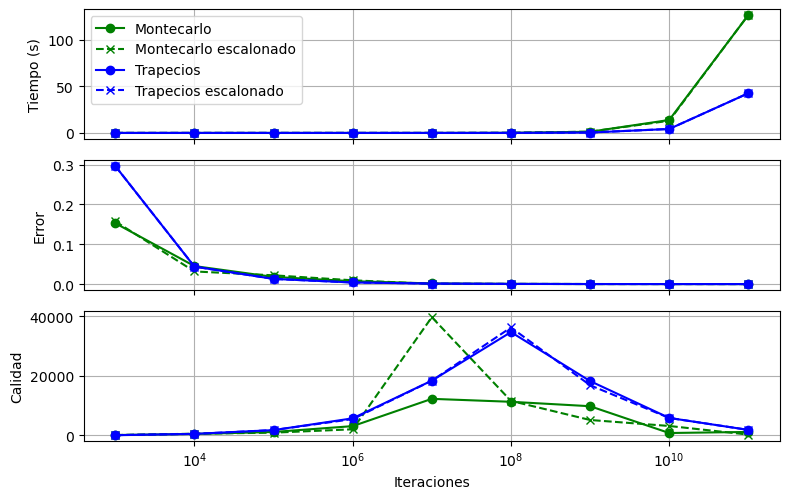

In [181]:
dfs = [mt, mt_es, tr, tr_es]
dfs = list(map(lambda df: df.loc[(df['nodos'] == 4) & (df['procesadores'] == 16) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="iteraciones", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_global_iteraciones", 
    colors=['green','green','blue','blue'], 
    markers=['o','x','o','x'],
    lines=['-','dashed','-','dashed'],
    labels=['Montecarlo', 'Montecarlo escalonado','Trapecios','Trapecios escalonado'],
    scale='log'
)

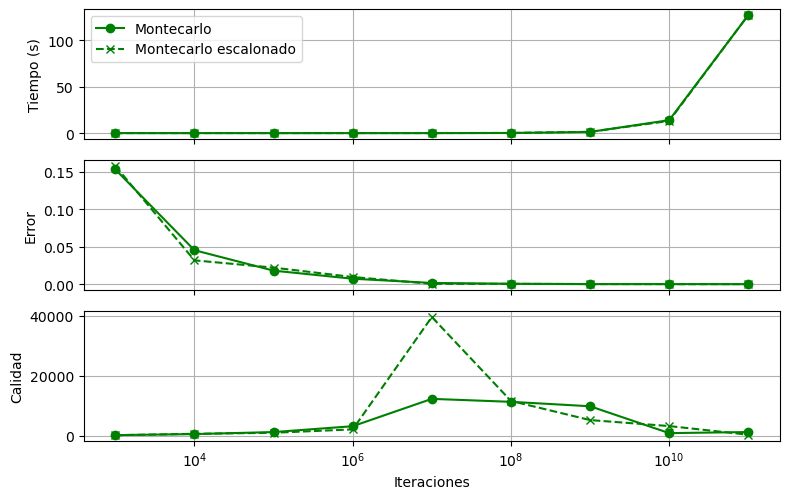

In [168]:
dfs = [mt, mt_es]
dfs = list(map(lambda df: df.loc[(df['nodos'] == 4) & (df['procesadores'] == 16) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="iteraciones", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_montecarlo_iteraciones", 
    colors=['green','green'], 
    markers=['o','x'],
    lines=['-','dashed'],
    labels=['Montecarlo', 'Montecarlo escalonado'],
    scale='log'
)

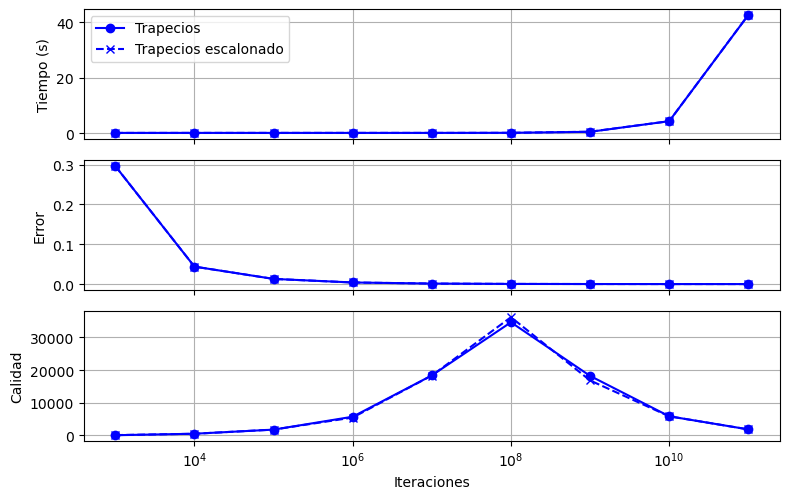

In [169]:
dfs = [tr, tr_es]
dfs = list(map(lambda df: df.loc[(df['nodos'] == 4) & (df['procesadores'] == 16) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="iteraciones", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_trapecios_iteraciones", 
    colors=['blue','blue'], 
    markers=['o','x'],
    lines=['-','dashed'],
    labels=['Trapecios','Trapecios escalonado'],
    scale='log'
)

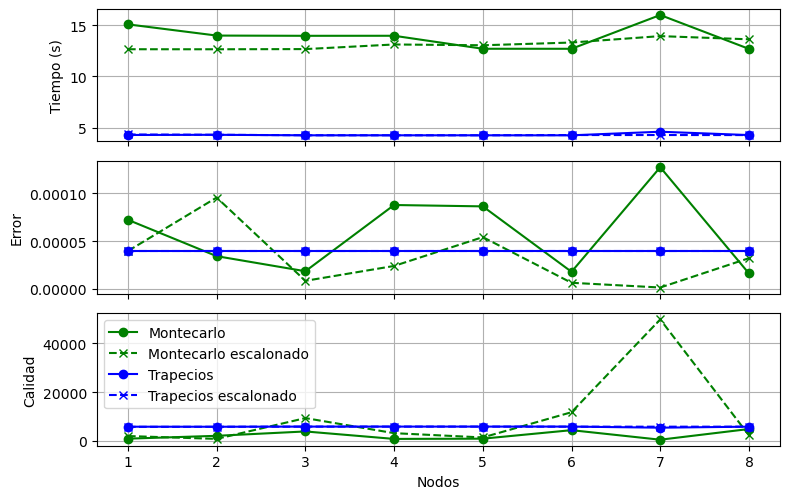

In [170]:
dfs = [mt, mt_es, tr, tr_es]
dfs = list(map(lambda df: df.loc[(df['iteraciones'] == 10000000000) & (df['procesadores'] == 16) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="nodos", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_global_nodos", 
    colors=['green','green','blue','blue'], 
    markers=['o','x','o','x'],
    lines=['-','dashed','-','dashed'],
    labels=['Montecarlo', 'Montecarlo escalonado','Trapecios','Trapecios escalonado'],
    legend_i=-1
)

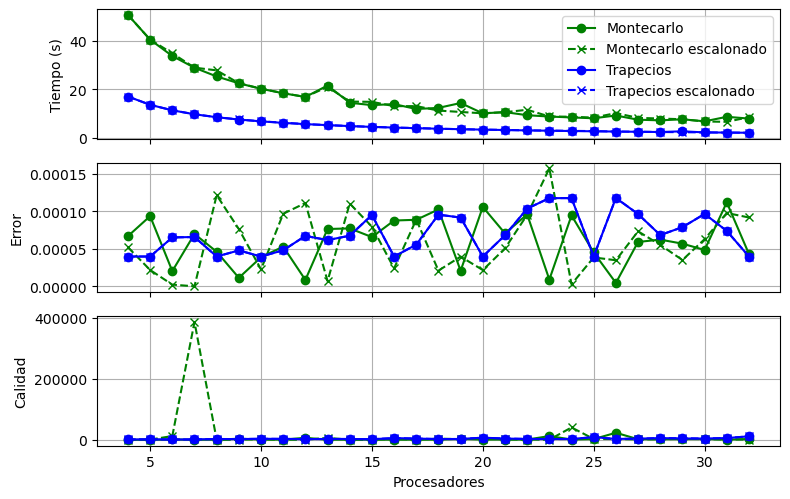

In [171]:
dfs = [mt, mt_es, tr, tr_es]
dfs = list(map(lambda df: df.loc[(df['iteraciones'] == 10000000000) & (df['nodos'] == 4) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="procesadores", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_global_procesadores", 
    colors=['green','green','blue','blue'], 
    markers=['o','x','o','x'],
    lines=['-','dashed','-','dashed'],
    labels=['Montecarlo', 'Montecarlo escalonado','Trapecios','Trapecios escalonado']
)

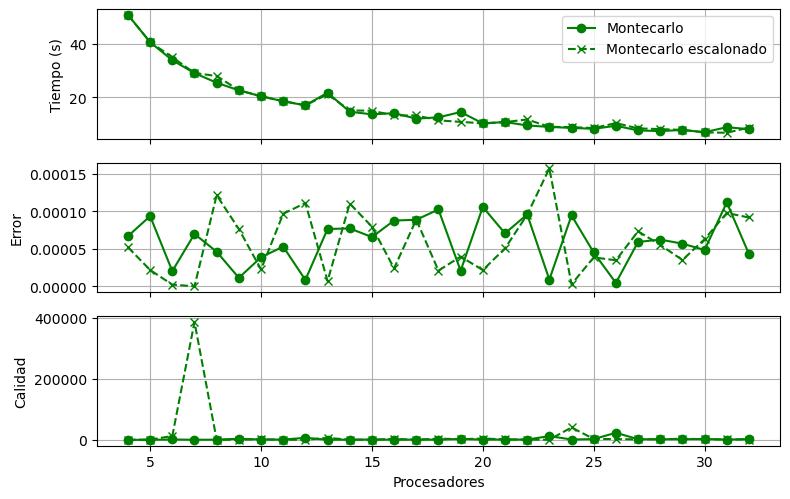

In [172]:
dfs = [mt, mt_es]
dfs = list(map(lambda df: df.loc[(df['iteraciones'] == 10000000000) & (df['nodos'] == 4) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="procesadores", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_montecarlo_procesadores", 
    colors=['green','green'], 
    markers=['o','x'],
    lines=['-','dashed'],
    labels=['Montecarlo', 'Montecarlo escalonado']
)

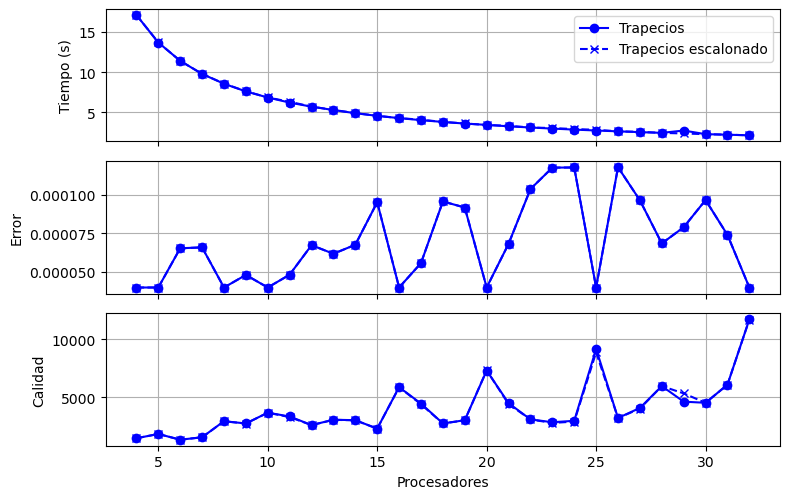

In [173]:
dfs = [tr, tr_es]
dfs = list(map(lambda df: df.loc[(df['iteraciones'] == 10000000000) & (df['nodos'] == 4) & (df['procesador'] == -1)], dfs))
_ = grafica(
    dfs, 
    x="procesadores", 
    y=["tiempo","error","calidad"],
    nombre="comparacion_trapecios_procesadores", 
    colors=['blue','blue'], 
    markers=['o','x'],
    lines=['-','dashed'],
    labels=['Trapecios','Trapecios escalonado']
)

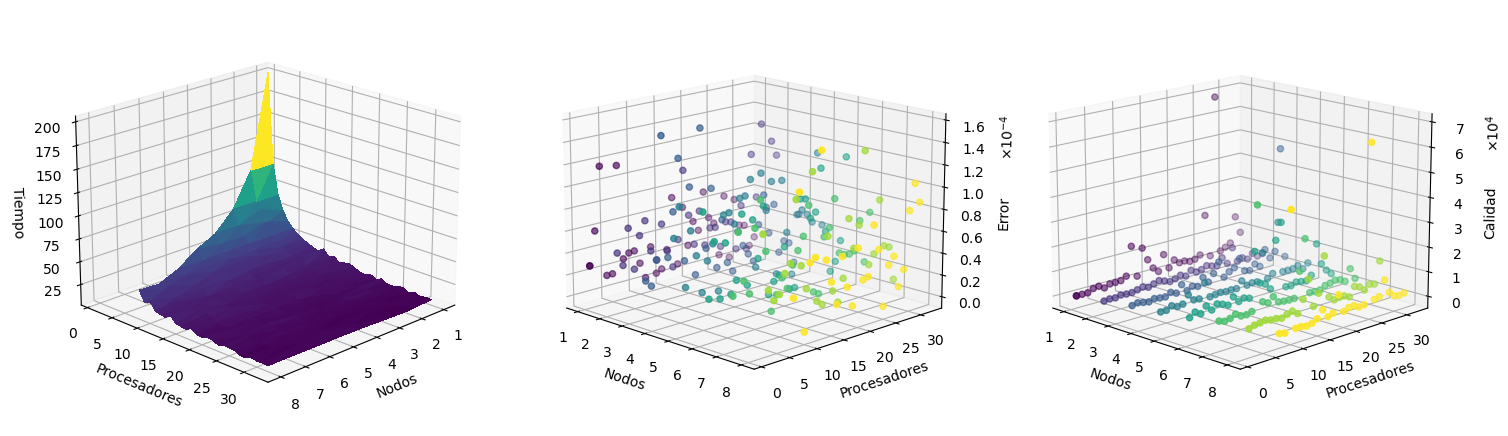

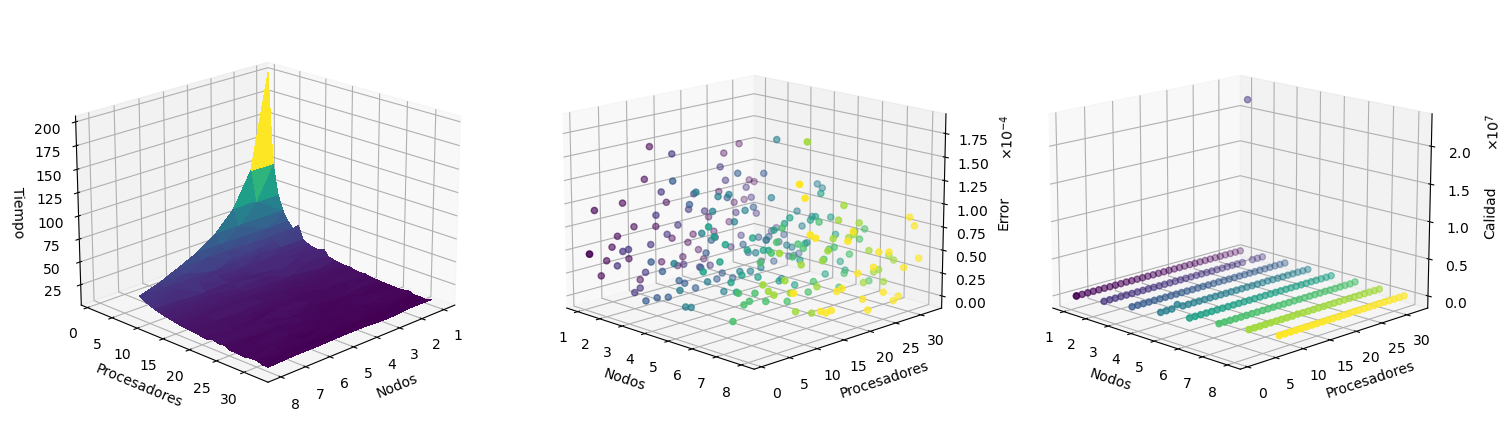

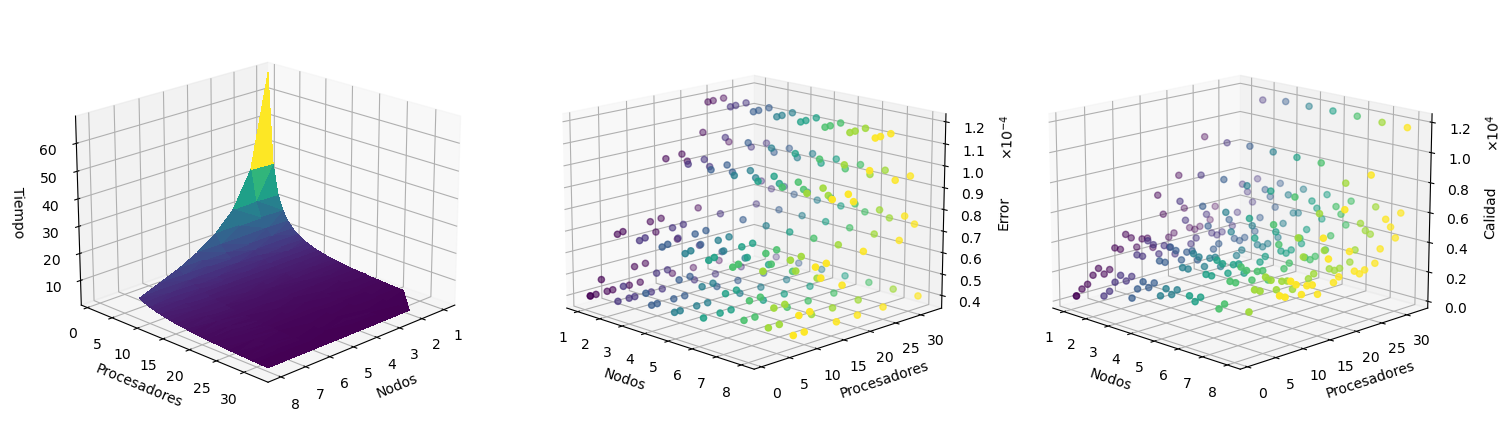

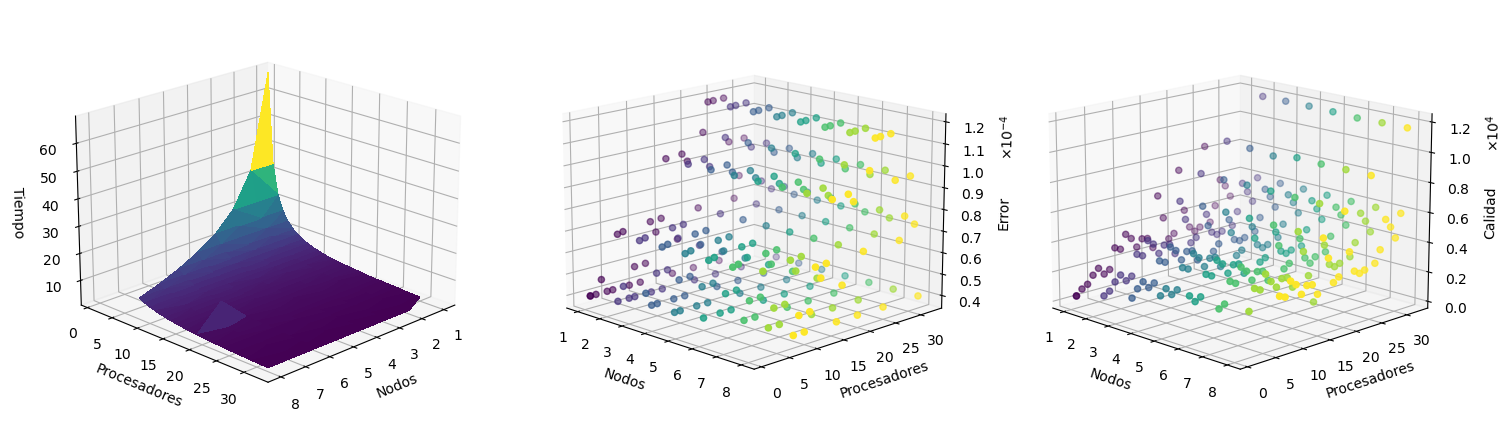

In [174]:
_ = grafica_3D(mt, "montecarlo")
_ = grafica_3D(mt_es, "montecarlo_escalonado")
_ = grafica_3D(tr, "trapecios")
_ = grafica_3D(tr_es, "trapecios_escalonado")

In [175]:
mt['tipo'] = 'mt'
mt_es['tipo'] = 'mt_es'
tr['tipo'] = 'tr'
tr_es['tipo'] = 'tr_es'

df_final = pd.concat([mt, mt_es, tr, tr_es], ignore_index=True)
df_final = df_final.sort_values(by='error')

df_final[df_final['procesador']==-1][['pi_approx','nodos','procesadores','iteraciones','tiempo','error','calidad','tipo']][:17].to_csv("top_error.csv", index=False)


In [176]:
df_final = df_final.sort_values(by='calidad', ascending=False)

df_final[df_final['procesador']==-1][['pi_approx','nodos','procesadores','iteraciones','tiempo','error','calidad','tipo']][:17].to_csv("top_calidad.csv", index=False)

In [177]:
df_final[(df_final['procesador']==-1) & ((df_final['tipo']=='tr') | (df_final['tipo']=='tr_es'))][['pi_approx','nodos','procesadores','iteraciones','tiempo','error','calidad','tipo']][:5].to_csv("top_error_trapecios.csv", index=False)

# Pruebas

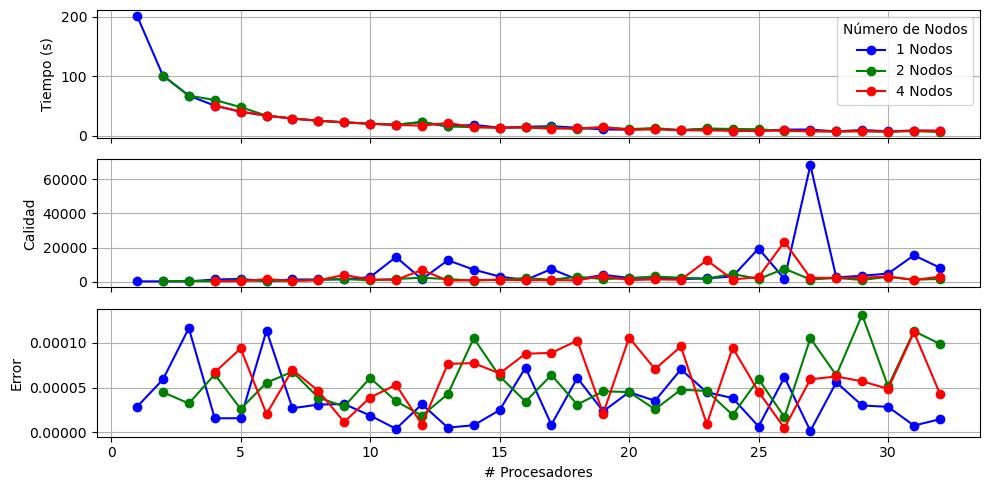

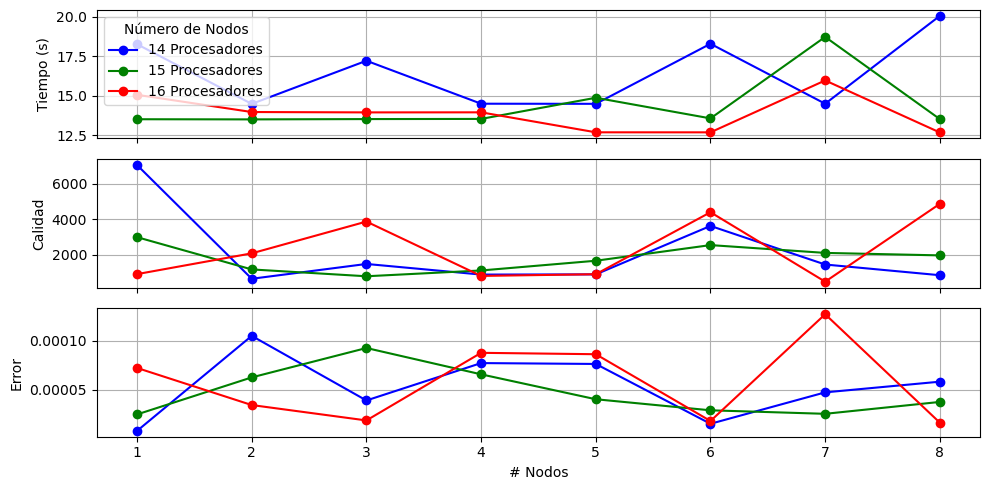

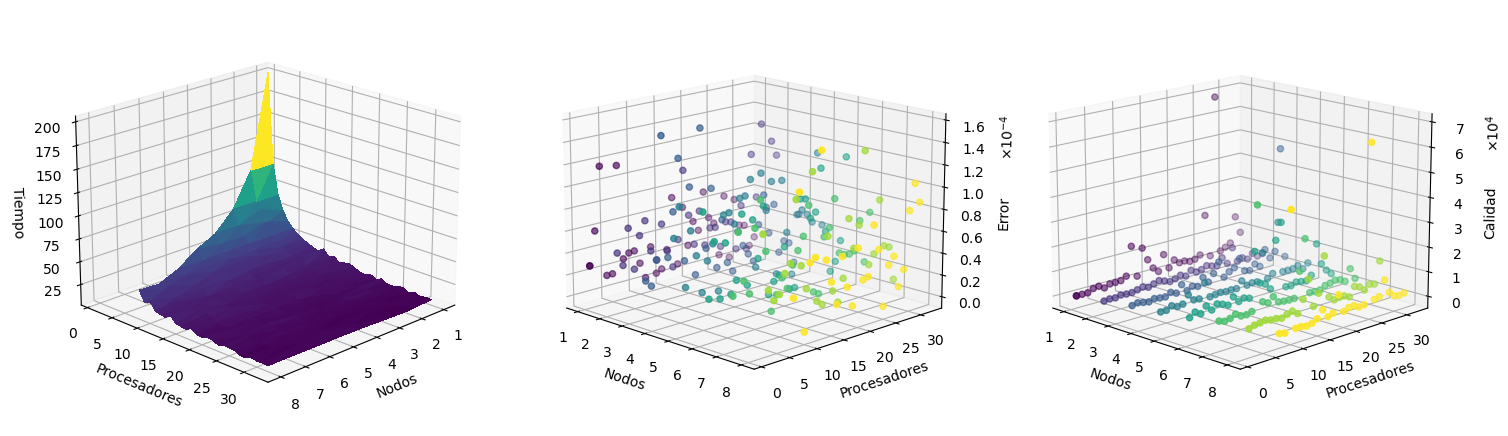

In [67]:
_ = grafica_en_funcion_de_procesadores(mt, "montecarlo", n_nodos=[1,2,4])
_ = grafica_en_funcion_de_nodos(mt, "montecarlo", n_procesadores=[14,15,16])
_ = grafica_3D(mt, "montecarlo")

No se encontró aproximación global para 1 nodos y 21 procesadores
No se encontró aproximación global para 1 nodos y 22 procesadores
No se encontró aproximación global para 1 nodos y 23 procesadores
No se encontró aproximación global para 1 nodos y 24 procesadores
No se encontró aproximación global para 1 nodos y 25 procesadores
No se encontró aproximación global para 1 nodos y 26 procesadores
No se encontró aproximación global para 1 nodos y 27 procesadores
No se encontró aproximación global para 1 nodos y 28 procesadores
No se encontró aproximación global para 1 nodos y 29 procesadores
No se encontró aproximación global para 1 nodos y 30 procesadores
No se encontró aproximación global para 1 nodos y 31 procesadores
No se encontró aproximación global para 1 nodos y 32 procesadores


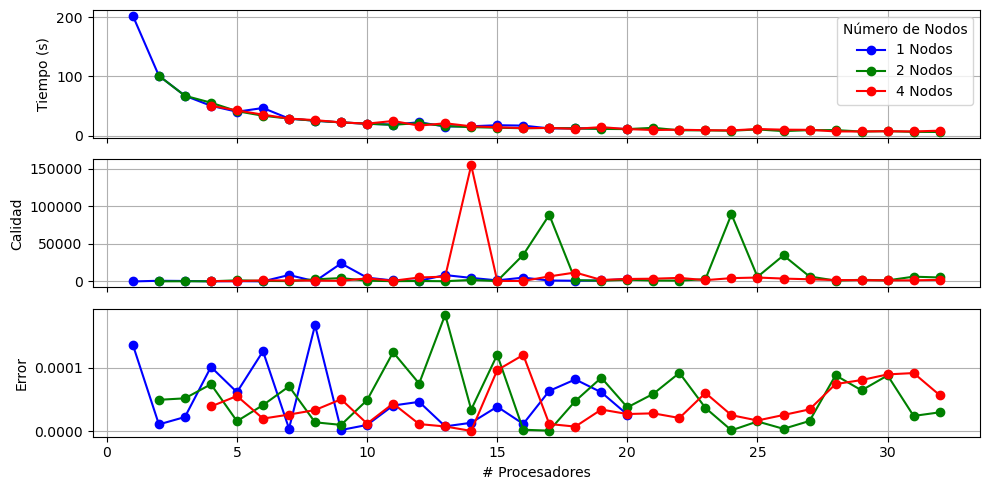

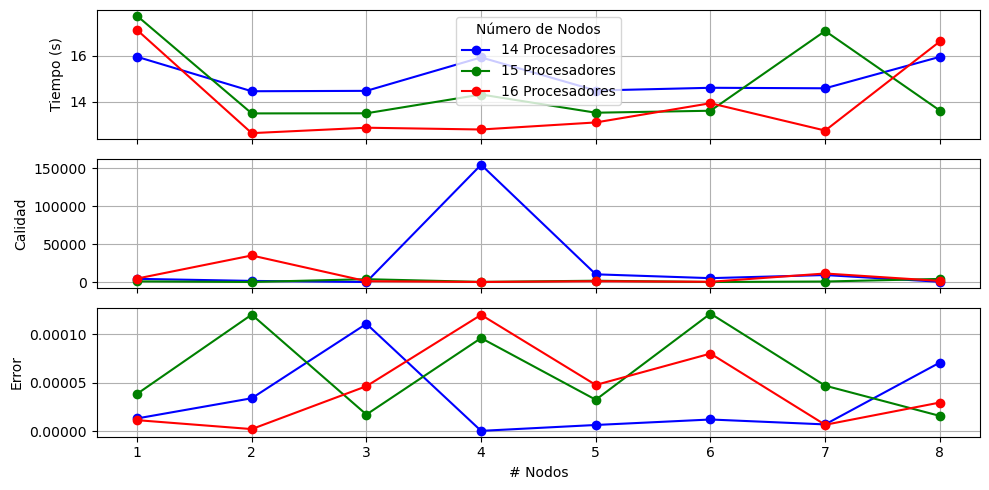

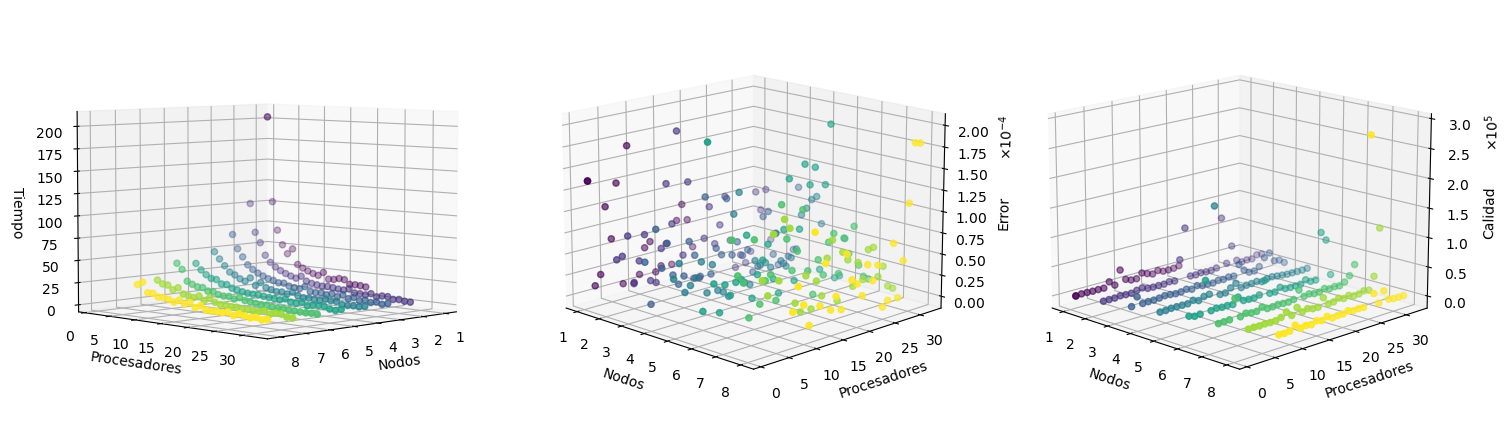

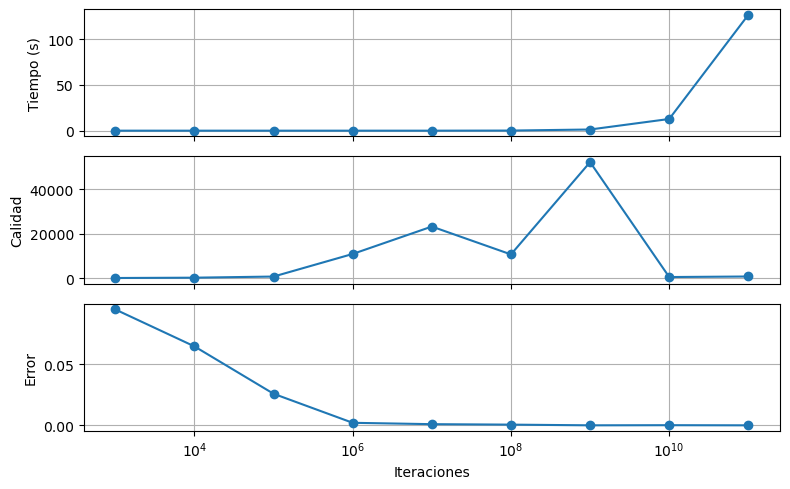

In [191]:
df = cargar_fichero("montecarlo_escalonado_2.out")
_ = grafica_en_funcion_de_procesadores(df, "montecarlo-escalonado", n_nodos=[1,2,4])
_ = grafica_en_funcion_de_nodos(df, "montecarlo-escalonado", n_procesadores=[14,15,16])
_ = grafica_3D(df, "montecarlo-escalonado")
_ = grafica_en_funcion_de_iteraciones(df, "montecarlo-escalonado")